In [1]:
import numpy as np
from scipy.special import expit
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
from estimate_SB import _gibbs_one_iter, schbridge, sinkhorn, cost_matrix
from matplotlib.animation import FuncAnimation
import time

In [2]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["axes.titlesize"] = 12
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
def cost_matrix(X, Y):
    """L2 cost matrix
    """
    n = X.shape[0]
    return (X.reshape((n,1)) - X.reshape((1,n)))**2

Suppose I have $(x_1, \dots, x_n)$ observed from $\rho_0$ to start with. I want to conduct an SB scheme on these samples for minimizing 
$$\mathcal{F} = \frac{1}{2} Ent(\rho).$$



In [4]:
n_list = 200*np.arange(1, 6)
gibbs_plan_list, cost_list, accept_ratio_list = [], [], []
eps = 0.01
mu, sigma_squared, sigma = 0, 4, 2
X_ = np.random.normal(mu, sigma, n_list[-1])
cost_mat = cost_matrix(X_, X_)

In [5]:
start = time.perf_counter()
gibbs_cost, gibbs_plan, costs, accept = schbridge(cost_mat, reg=eps, total=1000000, discard=0)
end = time.perf_counter()
print("Elapsed (with compilation) = {}s".format((end - start)))

In [5]:
start = time.perf_counter()
gibbs_cost, gibbs_plan, costs, accept = schbridge(cost_mat, reg=eps, total=1000000, discard=0)
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))

Elapsed (after compilation) = 347.0146139450371s


In [13]:
## Gibbs
for i in tqdm(range(len(n_list))):
    n = n_list[i]
    X = X_[:n]
    cost_mat = cost_matrix(X, X)
    gibbs_cost, gibbs_plan, all_costs, accept = schbridge(cost_mat, reg=eps, total=1000000, discard=10000)
    cumsum = np.cumsum(all_costs)
    cumavg = cumsum / np.arange(1, len(all_costs) + 1)
    gibbs_plan_list.append(gibbs_plan)
    cost_list.append(cumavg)
    accept_ratio_list.append(accept)

100%|██████████| 5/5 [12:16<00:00, 147.22s/it]


In [16]:
with open(f"cost_list_eps{eps}.pkl", "wb") as input_file:
    pkl.dump(cost_list, input_file)
    
with open(f"accept_ratio_list_eps{eps}.pkl", "wb") as input_file:
    pkl.dump(accept_ratio_list, input_file)
    
with open(f"gibbs_plan_list_eps{eps}.pkl", "wb") as input_file:
    pkl.dump(gibbs_plan_list, input_file)


In [17]:

with open(f"cost_list_eps{eps}.pkl", "rb") as input_file:
    cost_list = pkl.load(input_file)
    
with open(f"accept_ratio_list_eps{eps}.pkl", "rb") as input_file:
    accept_ratio_list = pkl.load(input_file)
    
with open(f"gibbs_plan_list_eps{eps}.pkl", "rb") as input_file:
    gibbs_plan_list = pkl.load(input_file)


[]

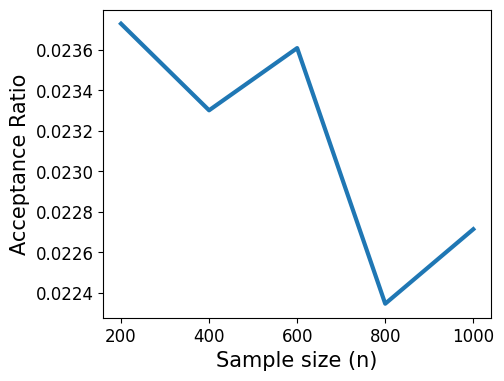

In [18]:
plt.figure(figsize=(5,4))
plt.plot(n_list, accept_ratio_list)
plt.xlabel('Sample size (n)')
plt.ylabel('Acceptance Ratio')
plt.plot()

/tmp/ipykernel_3788277/4026602482.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


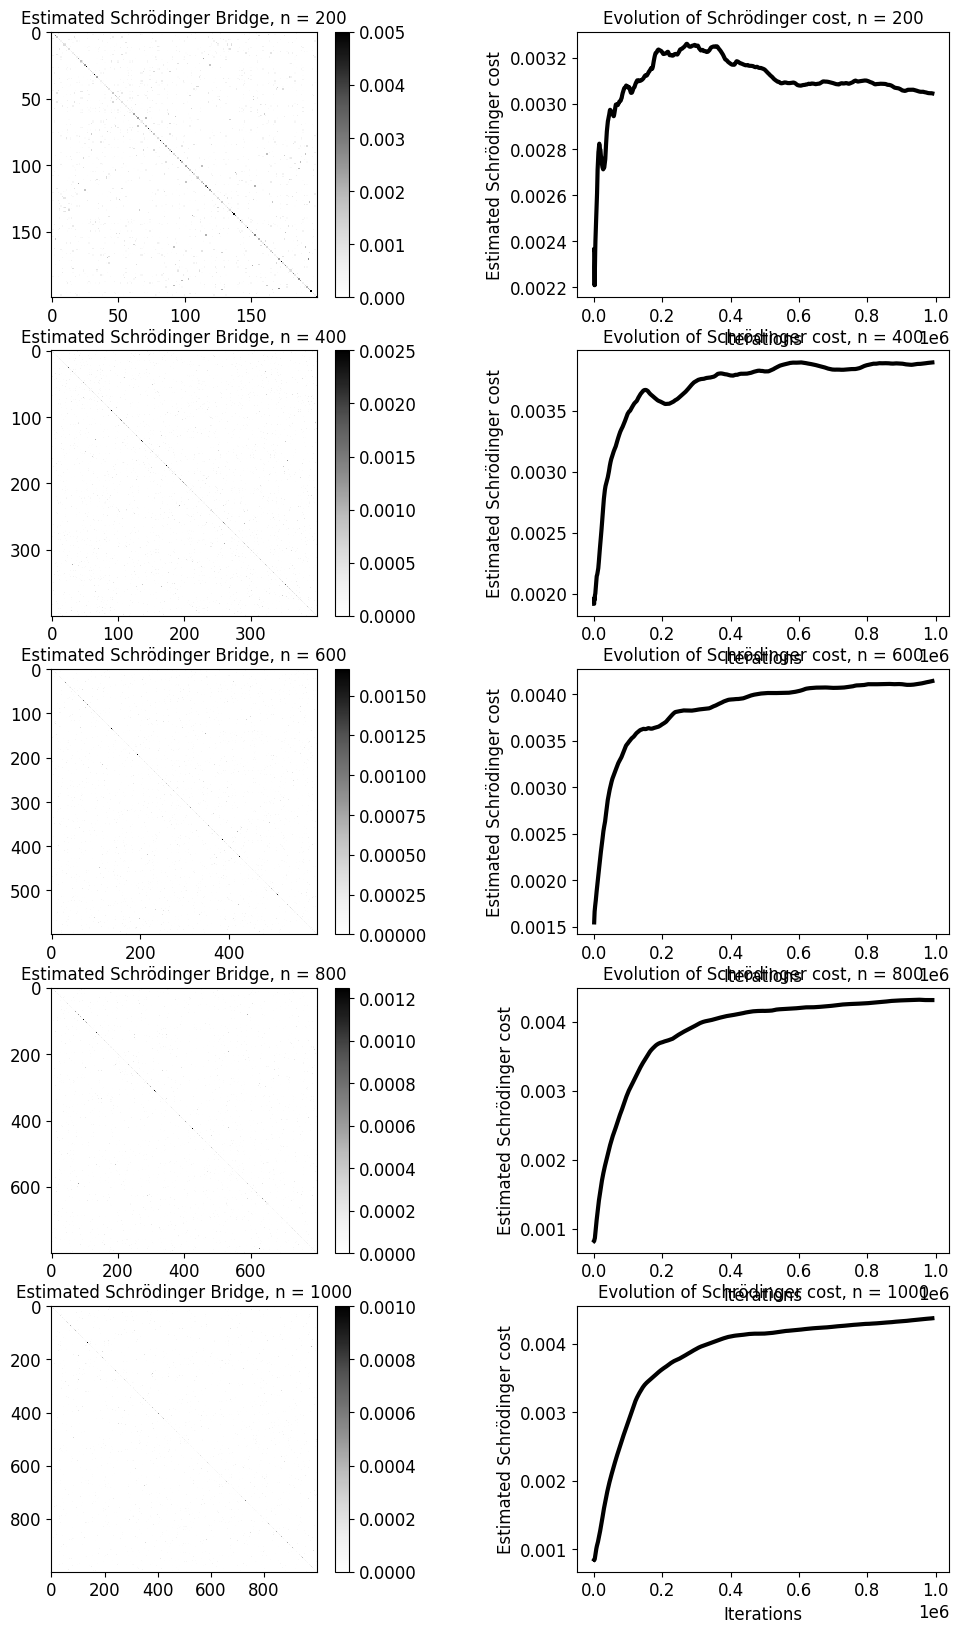

In [23]:
fig, axs = plt.subplots(len(n_list), 2, figsize=(12,4*len(n_list)), gridspec_kw={'wspace': .5})

for i in range(len(n_list)):
    axs[i,0].imshow(gibbs_plan_list[i], cmap='Greys', interpolation='nearest')
    axs[i,0].figure.colorbar(axs[i,0].images[0], ax=axs[i,0])
    axs[i,0].set_title(f"Estimated Schrödinger Bridge, n = {n_list[i]}")
    axs[i,1].plot(np.arange(len(cost_list[i]))+1, cost_list[i], color='black')
    axs[i,1].set_xlabel('Iterations')
    axs[i,1].set_ylabel('Estimated Schrödinger cost')
    axs[i,1].set_title(f"Evolution of Schrödinger cost, n = {n_list[i]}")

plt.tight_layout()
plt.show()

/tmp/ipykernel_3788277/598508118.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


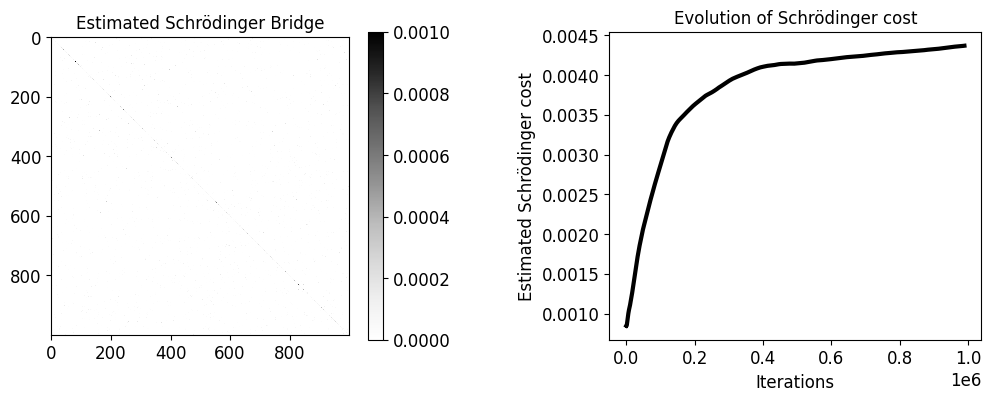

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'wspace': .5})
axs[0].imshow(gibbs_plan_list[-1], cmap='Greys', interpolation='nearest',)
axs[0].figure.colorbar(axs[0].images[0], ax=axs[0])
axs[0].set_title(f"Estimated Schrödinger Bridge")
axs[1].plot(np.arange(len(cost_list[i]))+1, cost_list[i], color='black')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Estimated Schrödinger cost')
axs[1].set_title(f"Evolution of Schrödinger cost")

plt.tight_layout()
plt.show()

In [4]:
# Create Particles for forward process
n = 500
eps = 0.001
mu, sigma_squared, sigma = 0, 4, 2
X = np.random.normal(mu, sigma, n)
cost_mat = cost_matrix(X, X)

In [7]:
# using MCMC for Schrödinger bridge
start = time.perf_counter()
gibbs_cost, gibbs_plan, costs, accept = schbridge(cost_mat, reg=eps, total=1e6, discard=1e4)
end = time.perf_counter()
print("Gibbs time = {}s".format((end - start)))

# using Sinkhorn for Schrödinger bridge
start = time.perf_counter()
sink_cost, sink_plan = sinkhorn(cost_mat, np.ones(n)/n, np.ones(n)/n, eps, precision=1e-30, maxiter=1e4)
end = time.perf_counter()
print("Sinkhorn time = {}s".format((end - start)))

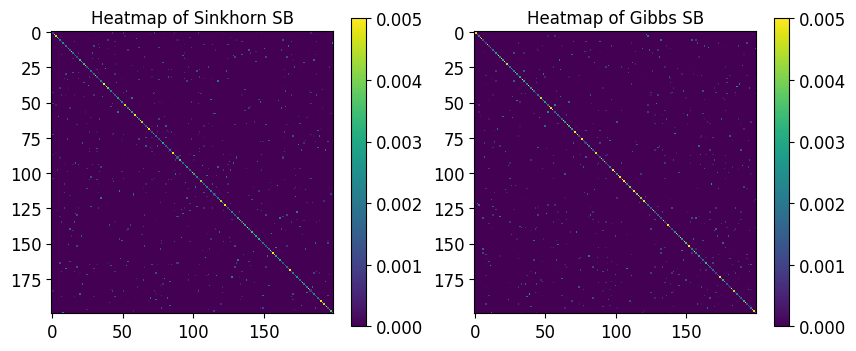

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
# Create a heatmap
axs[0].imshow(sink_plan, cmap='viridis', interpolation='nearest')
axs[1].imshow(gibbs_plan, cmap='viridis', interpolation='nearest')
for ax in axs:
    ax.figure.colorbar(ax.images[0], ax=ax)

# Show the plot
axs[0].set_title('Heatmap of Sinkhorn SB')
axs[1].set_title('Heatmap of Gibbs SB')
plt.show()

In [ ]:
np.sum(np.diag(gibbs_plan))

Now let's calculate the Schrodinger bridge between $\rho_n$ and $\rho_n$.

Recall that the SB scheme with the starting measure $\rho$ is
$$\rho_\epsilon^* = (Id + \nabla f_{\epsilon, \rho})_\# \rho$$
Now the SB scheme is 
$$x_i \mapsto x_i + \nabla f_{\epsilon, \rho_n}(x_i)$$
We know that $E_{\pi_{\epsilon, \rho_n}}[Y | X = x_i] = x_i - \nabla f_{\epsilon, \rho_n}(x_i)$. Therefore, we want to calculate the barycentric projection using an approximation of $\pi_{\epsilon, \rho_n}$. 

Let this be $\hat{\pi}_{\epsilon, \rho_n}$ calculated using method above using Sinkhorn or Gibbs sampling. Then we have that $\hat{\pi}_{\epsilon, \rho_n} \in [0,1]^{n \times n}$ is matrix. And note that
\begin{align*}
\nabla \hat{f}_{\epsilon, \rho_n}(x_i) &= x_i - E_{\hat{\pi}_{\epsilon, \rho_n}}[Y|X=x_i]\\
&= x_i - \frac{\sum_{j=1}^n x_j \hat{\pi}_{\epsilon, \rho_n}^{ij}}{\rho_n(x_i)}\\
&= x_i - n\sum_{j=1}^n x_j \hat{\pi}_{\epsilon, \rho_n}^{ij}\\
\end{align*}

Finally, we have the estimated SB scheme as
$$x_i \mapsto 2x_i- n\sum_{j=1}^n x_j \hat{\pi}_{\epsilon, \rho_n}^{ij}$$


In [5]:
def entropy_SB_scheme_gibbs(X, steps=[1], reg=0.001, total=5000, discard=1000, forward=True):
    start = X
    n = X.shape[0]
    total_steps = steps[-1]
    X_list = []
    for i in tqdm(range(total_steps)):
        cost_mat = cost_matrix(X, X)
        avg_cost, avg_plan, _, _ = schbridge(cost_mat, reg=eps, total=1e6, discard=1e4)
        bar_proj = n*np.matmul(avg_plan, X.reshape(n,1)).reshape(n,)

        if forward:
            X = 2*X - bar_proj
        else:
            X = bar_proj

        if i+1 in steps:
            X_list.append(X)
            print(f'Epsilon: {eps}, Steps: {i+1}, Distance from start: {np.linalg.norm(start-X_list[-1])}')

    return np.array(X_list)

def entropy_SB_scheme_sinkhorn(X, steps=[1], eps=0.001, precision=1e-30, maxiter=10000, forward=True):
    start = X
    n = X.shape[0]
    total_steps = steps[-1]
    X_list = []
    for i in tqdm(range(total_steps)):
        cost_mat = cost_matrix(X, X)
        avg_cost, avg_plan = sinkhorn(cost_mat, np.ones(n)/n, np.ones(n)/n, epsilon=eps, precision=precision, maxiter=maxiter)
        bar_proj = n*np.matmul(avg_plan, X.reshape(n,1)).reshape(n,)
        if forward:
            X = 2*X - bar_proj
        else:
            X = bar_proj

        if i+1 in steps:
            X_list.append(X)
            print(f'Epsilon: {eps}, Steps: {i+1}, Distance from start: {np.linalg.norm(start-X)}')
    return np.array(X_list)

In [ ]:
for e in [0.1, 0.01, 0.001]: 

    max_steps = int(2/e)
    steps = np.arange(1, (max_steps//10)+1)

    ## Gibbs
    X_SB_Gibbs = entropy_SB_scheme_gibbs(X, steps=steps, reg=e, total=1e6, discard=1e4)

    # Save multiple arrays into a single .npz file
    file_path = f'X_SB_Gibbs_forward_eps{e}.npy'
    np.save(file_path, X_SB_Gibbs)


    print(f'Epsilon: {e} -->  Gibbs: {np.linalg.norm(X - X_SB_Gibbs[-1])}')


In [15]:
# Create particles for reverse process

n = 500
eps = 0.001
mu, sigma_squared, sigma = 0, 6, np.sqrt(6)
X_ = np.random.normal(mu, sigma, n)
cost_mat = cost_matrix(X_, X_)

In [ ]:
for e in [0.1, 0.01, 0.001]: 

    max_steps = int(2/e)
    steps = 10*np.arange(1, (max_steps//10)+1)

    ## Gibbs
    X_SB_Gibbs = entropy_SB_scheme_gibbs(X_, steps=steps, reg=e, total=1e6, discard=1e4, forward=False)

    # Save multiple arrays into a single .npz file
    file_path = f'X_SB_Gibbs_reverse_eps{e}.npy'
    np.savez(file_path, X_SB_Gibbs)


    print(f'Epsilon: {e} -->  Gibbs: {np.linalg.norm(X - X_SB_Gibbs[-1])}')


In [11]:
def draw_gaussian(mean, std_dev):
    # Generate data points for the x-axis
    x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)

    # Compute the probability density function (PDF) for each data point
    pdf_values = norm.pdf(x, mean, std_dev)

    return x, pdf_values

def forward_SB_var(sigma_squared, eps, k=1):

    new_sigma_squared = ((2 - (sigma_squared/(np.sqrt((sigma_squared**2) + (eps**2)/4) + eps/2)))**2)*sigma_squared

    if k==1:
        return new_sigma_squared
    else:
        return forward_SB_var(new_sigma_squared, eps, k=k-1)

def reverse_SB_var(sigma_squared, eps, k=1):

    new_sigma_squared = ((sigma_squared/(np.sqrt((sigma_squared**2) + (eps**2)/4) + eps/2))**2)*sigma_squared

    if k==1:
        return new_sigma_squared
    else:
        return reverse_SB_var(new_sigma_squared, eps, k=k-1)

In [38]:
def update_plot(frame, SB_steps, steps, eps, sigma_squared, forward, xlim, ylim):
    plt.clf()  # Clear the previous plot (if any)
    
    # Your plotting logic for each frame
    step = steps[frame]
    plt.hist(SB_steps[frame], density=True, alpha=0.6, bins=30, color='lightblue', edgecolor='white')
    plt.title(f'Steps: {step}, Time: {eps*step}')
    plt.xlim(-xlim, xlim)
    plt.ylim(0, ylim)

    if forward:
        true_var = sigma_squared + step*eps
        SB_var = forward_SB_var(sigma_squared, eps, k=step)
    else:
        true_var = sigma_squared - step*eps
        SB_var = reverse_SB_var(sigma_squared, eps, k=step)

    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(true_var))
    plt.plot(x, pdf_values, label=r'$\rho_t$', color='blue', linewidth=4)
    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(SB_var))
    plt.plot(x, pdf_values, label=r'$\rho^*_t$', color='green')
    plt.legend()

In [ ]:
# Create forward animations

mu, sigma_squared, sigma = 0, 4, 2
for e in [0.1, 0.01, 0.001]: 

    max_steps = int(2/e)
    steps = 10*np.arange(1, (max_steps//10)+1)

    # Set the number of frames
    num_frames = len(steps)

    ## Gibbs
    file_path = f'X_SB_Gibbs_forward_eps{e}.npy'
    X_SB_Gibbs = np.load(file_path)

    # Create a figure
    fig, ax = plt.subplots()

    # Create the animation
    animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB_Gibbs, steps, e, sigma_squared, True, 3*np.sqrt(6), .2), interval=10)
    animation.save(f'Gibbs_forward_Entropy_Eps{e}.gif', writer='imagemagick', fps=2)
    # Show the animation
    plt.show()


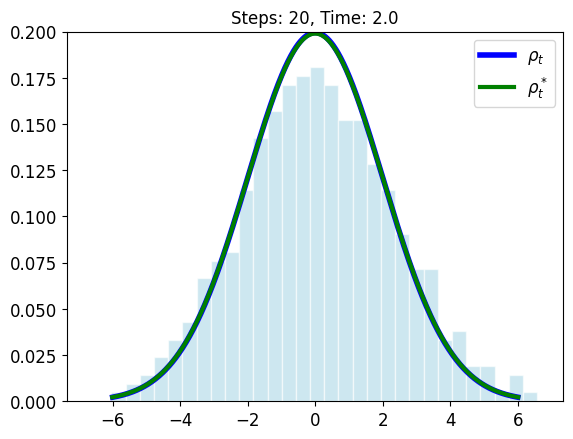

FileNotFoundError: [Errno 2] No such file or directory: 'X_SB_Gibbs_reverse_eps0.01.npy'

In [41]:
# Create reverse animations

mu, sigma_squared, sigma = 0, 6, np.sqrt(6)
for e in [0.1, 0.01, 0.001]: 

    max_steps = int(2/e)
    steps = 10*np.arange(1, (max_steps//10)+1)

    # Set the number of frames
    num_frames = len(steps)

    ## Gibbs
    file_path = f'X_SB_Gibbs_reverse_eps{e}.npy'
    X_SB_Sink = np.load(file_path)

    # Create a figure
    fig, ax = plt.subplots()

    # Create the animation
    animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB_Gibbs, steps, e, sigma_squared, False, 3*np.sqrt(6), .2), interval=10)
    animation.save(f'Gibbs_reverse_Entropy_Eps{e}.gif', writer='imagemagick', fps=2)
    # Show the animation
    plt.show()


In [49]:
import numpy as np

def custom_resample(original_array, acceptance_probs):
    n = len(original_array)
    resampled_indices = []
    first_occurrence_indices = {}

    while len(set(resampled_indices)) < n:
        # Use numpy's random.choice to resample indices with specified probabilities
        chosen_index = np.random.choice(n, p=acceptance_probs)
        # print(chosen_index)

        # Mark the index as resampled
        resampled_indices.append(chosen_index)

        # Record the first occurrence index for each unique element
        element = original_array[chosen_index]
        if element not in first_occurrence_indices:
            first_occurrence_indices[element] = len(resampled_indices)-1

    # Create the resampled array
    resampled_array = original_array[list(resampled_indices)]

    # Create a list of first occurrence indices for each unique element
    first_occurrence_indices_list = [first_occurrence_indices[element] for element in original_array]

    return resampled_array, first_occurrence_indices_list

# Example usage:
original_array = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
acceptance_probs = np.array([0.1, 0.1, 0.1, 0.1, 0.6])

resampled_result, first_occurrence_indices = custom_resample(original_array, acceptance_probs)

print("Original array:", original_array)
print("Resampled array:", resampled_result)
print("First occurrence indices:", first_occurrence_indices)


Original array: [1. 2. 3. 4. 5.]
Resampled array: [5. 5. 5. 5. 4. 1. 2. 1. 1. 5. 5. 5. 2. 1. 3.]
First occurrence indices: [5, 6, 14, 4, 0]
